# apo05 Workflow Demo
This is the demo data we've used a lot... it's originally from SLH, used to teach APO observing class for years!

Use it to debug all the functions, flush out the slightly updated workflow

Not a robust tutorial, but useful!

## UPDATE
This updated version now uses the Dynamic Time Warping function to solve the wavelength. This approach works even though
- the red wavelength solution is backwards
- we are missing a Helium line template

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

# file-handling stuff for user, options abound! I like Tables and Pandas DataFrames
import pandas as pd
from astropy.table import Table
from astropy import units as u
from specutils import Spectrum1D

import pykosmos as pk
pk.__version__

'0.3.8.1'

In [2]:
# should we make a whole bunch of plots?
DISPLAY = True

## 1. Bias

In [3]:
# to run on data, the user should provide lists of files to reduce.
# we can do this via the old IRAF way for now (b/c I'm old fashioned),
# but probably could design a more pythonic way (e.g. w/ glob or similar)

dir = '../../pykosmos_testdata/slh05_test/apo05/'
biasfiles_i = pd.read_table(dir + 'biaslist.txt', names=['impath'])
biasfiles = dir + biasfiles_i['impath'].values
biasfiles

array(['../../pykosmos_testdata/slh05_test/apo05/05may31.0022r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0023r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0024r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0025r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0026r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0027r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0028r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0029r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0030r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0031r.fits'],
      dtype=object)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(1078, 2098)


/Users/james/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


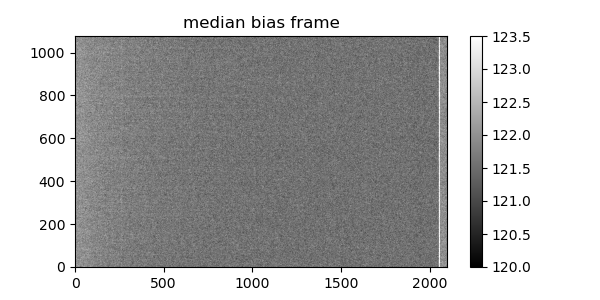

In [4]:
# use simple wrapper for median bias combining
bias = pk.biascombine(biasfiles) 
print(bias.shape)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(bias, origin='lower', aspect='auto', cmap=plt.cm.gray)
    plt.title('median bias frame')
    plt.clim(np.percentile(bias, (5, 98)))
    cb = plt.colorbar()

## 2. Flat

In [5]:
flatfiles_i = pd.read_table(dir + 'flatlist.txt', names=['impath'])
flatfiles = dir + flatfiles_i['impath'].values
flatfiles

array(['../../pykosmos_testdata/slh05_test/apo05/05may31.0037r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0038r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0039r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0040r.fits',
       '../../pykosmos_testdata/slh05_test/apo05/05may31.0041r.fits'],
      dtype=object)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(748,)
(748, 2048)
adu / s


/Users/james/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


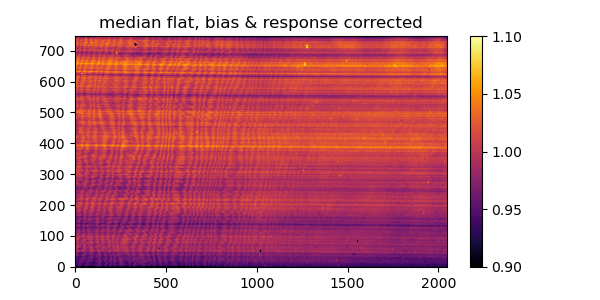

In [6]:
# a wrapper around Combiner, the spectral response normalization, and the illumination correction
# this should work WITH or WITHOUT a bias given
flat, ilum = pk.flatcombine(flatfiles, bias=bias)

print(ilum.shape) # this is the indicies that are illuminated
print(flat.shape)
print(flat.unit)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(flat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median flat, bias & response corrected')
    cb = plt.colorbar()

(1028, 2048)
adu / s


/Users/james/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


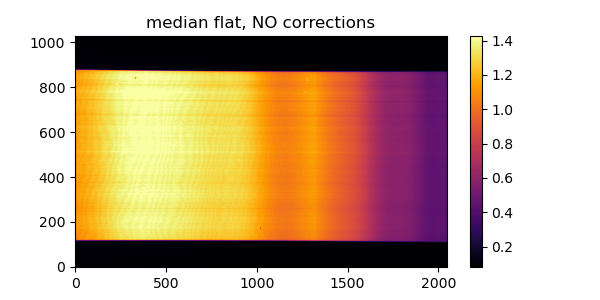

In [7]:
# if you turn off the illumination and response corrections, you just get a normalized median combined image
# i.e. could be used for photometry
medflat = pk.flatcombine(flatfiles, illumcor=False, responsecor=False)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(medflat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(np.percentile(medflat, (5, 98)))
    plt.title('median flat, NO corrections')
    cb = plt.colorbar()

print(medflat.shape)
print(medflat.unit)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(748, 2048)
adu / s


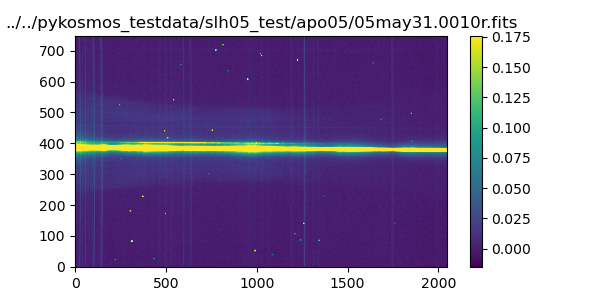

In [8]:
# how to read in any science or calibration frame w/ a spectrum present

sci = dir + '05may31.0010r.fits'  # spectrum of the one target star, Gl 669A
sciimg = pk.proc(sci, bias=bias, ilum=ilum, flat=flat, trim=True)

print(sciimg.shape)
print(sciimg.unit)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(sciimg, origin='lower', aspect='auto')
    plt.clim(np.percentile(sciimg, (5, 98)))
    cb = plt.colorbar()
    plt.title(sci)

(748, 2048)
adu / s


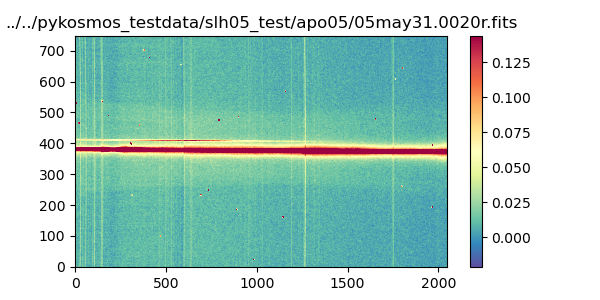

In [9]:
fcal = dir + '05may31.0020r.fits' # Flux std star observation, BD+282411

calimg = pk.proc(fcal, bias=bias, ilum=ilum, flat=flat, trim=True)
print(sciimg.shape)
print(sciimg.unit)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(calimg, origin='lower', aspect='auto', cmap=plt.cm.Spectral_r)
    plt.clim(np.percentile(calimg, (5, 98)))
    cb = plt.colorbar()
    plt.title(fcal)

## 4. Trace & Extract

/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_87655/131623982.py:1: DeprecationWarning: PyKOSMOS trace is now a wrapper for functions within specreduce.tracing, and is kept for backwards compatibility. More features are available from specreduce.tracing.
  cal_trace = pk.trace(calimg, display=DISPLAY, nbins=25)


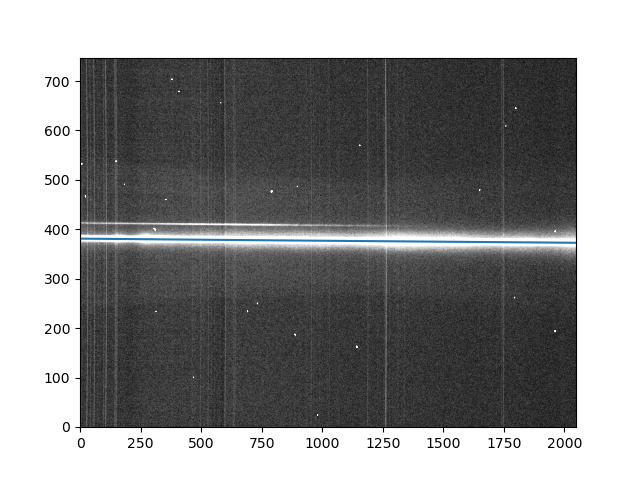

/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_87655/131623982.py:2: DeprecationWarning: PyKOSMOS trace is now a wrapper for functions within specreduce.tracing, and is kept for backwards compatibility. More features are available from specreduce.tracing.
  sci_trace = pk.trace(sciimg, display=False, nbins=55)


(2048,)

In [10]:
cal_trace = pk.trace(calimg, display=DISPLAY, nbins=25)
sci_trace = pk.trace(sciimg, display=False, nbins=55)

sci_trace.shape

In [11]:
sci_spectrum = pk.BoxcarExtract(sciimg, sci_trace, apwidth=10, skysep=10, skywidth=10)
cal_spectrum = pk.BoxcarExtract(calimg, cal_trace, apwidth=10, skysep=10, skywidth=10)

/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_87655/3344779178.py:1: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  sci_spectrum = pk.BoxcarExtract(sciimg, sci_trace, apwidth=10, skysep=10, skywidth=10)
/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_87655/3344779178.py:2: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  cal_spectrum = pk.BoxcarExtract(calimg, cal_trace, apwidth=10, skysep=10, skywidth=10)


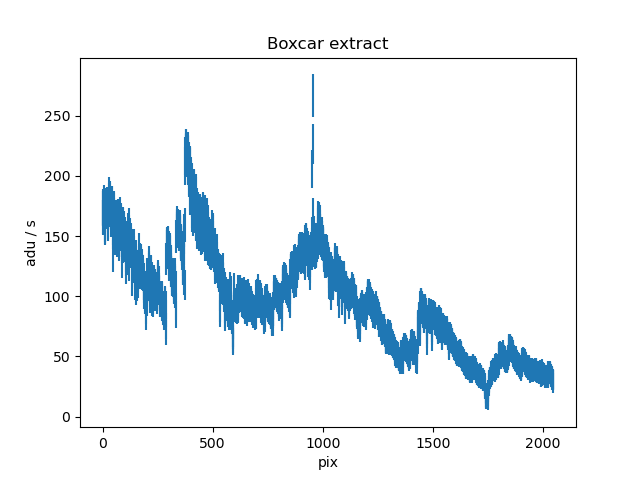

In [12]:
if DISPLAY:
    plt.figure()
    plt.errorbar(sci_spectrum.spectral_axis.value, sci_spectrum.flux.value, 
                 yerr=sci_spectrum.uncertainty.array, linestyle='none')
    plt.xlabel(sci_spectrum.spectral_axis.unit)
    plt.ylabel(sci_spectrum.flux.unit)
    plt.title('Boxcar extract')

## 5. Wavelength Calibration

In [13]:
# what calibrated arc templates are available?
# (we should build some explicitly for ALL lamps at APO!)
pk.loadarctemplate(help=True)


['/Users/james/anaconda3/lib/python3.11/site-packages/pykosmos/resources/arctemplates/DIS_B400.spec',
 '/Users/james/anaconda3/lib/python3.11/site-packages/pykosmos/resources/arctemplates/KrRed0.86-high.spec',
 '/Users/james/anaconda3/lib/python3.11/site-packages/pykosmos/resources/arctemplates/DIS_R300.spec',
 '/Users/james/anaconda3/lib/python3.11/site-packages/pykosmos/resources/arctemplates/KrRed1.18-ctr.spec',
 '/Users/james/anaconda3/lib/python3.11/site-packages/pykosmos/resources/arctemplates/KrBlue1.18-ctr.spec',
 '/Users/james/anaconda3/lib/python3.11/site-packages/pykosmos/resources/arctemplates/KrBlue0.86-high.spec',
 '/Users/james/anaconda3/lib/python3.11/site-packages/pykosmos/resources/arctemplates/ArRed2.0-low.spec',
 '/Users/james/anaconda3/lib/python3.11/site-packages/pykosmos/resources/arctemplates/NeBlue2.0-low.spec',
 '/Users/james/anaconda3/lib/python3.11/site-packages/pykosmos/resources/arctemplates/ArRed1.18-ctr.spec',
 '/Users/james/anaconda3/lib/python3.11/site

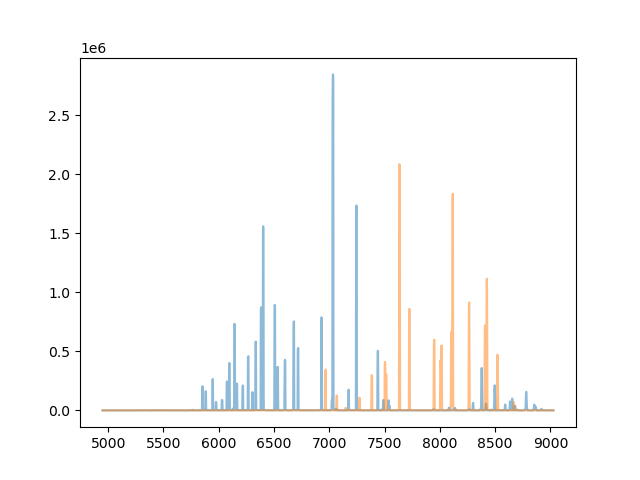

In [14]:
# for DIS-high red, KOSMOS red-ctr or red-low is approximately correct...
# for DIS-low red, might need to stich red-low and red-ihigh together? 
temp1 = pk.loadarctemplate('NeRed2.0-low.spec') # new
temp2 = pk.loadarctemplate('ArRed2.0-low.spec') # new

plt.figure()
plt.plot(temp1.spectral_axis, temp1.flux.value, alpha=0.5)
plt.plot(temp2.spectral_axis, temp2.flux.value, alpha=0.5)

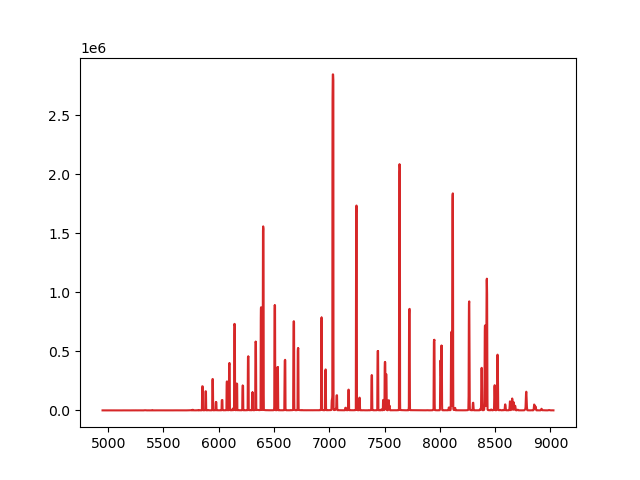

In [15]:
# build new template from multiple KOSMOS templates
NeAr = Spectrum1D(flux=(temp1.flux.value + temp2.flux.value) * temp1.flux.unit,  
                  spectral_axis=temp1.spectral_axis)

plt.figure()
plt.plot(NeAr.spectral_axis, NeAr.flux.value, c='C3')

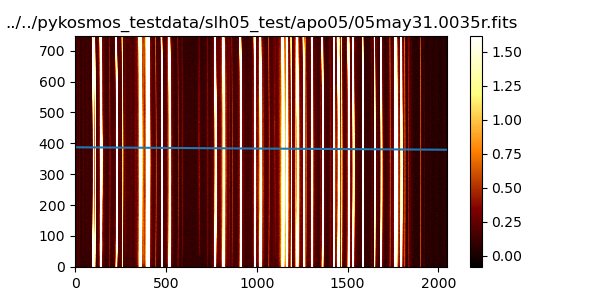

In [24]:
arcfile = dir + '05may31.0035r.fits' # HeNeAr lamp

# read and process in the ARC LAMP, just like a normal spectrum
arcimg = pk.proc(arcfile, bias=bias, ilum=ilum, trim=True) 

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(arcimg, origin='lower', aspect='auto', cmap=plt.cm.afmhot)
    plt.plot(np.arange(len(sci_trace)), sci_trace) # for illustration, overplot the trace 
    plt.clim(np.percentile(arcimg, (1, 90.6)))
    cb = plt.colorbar()
    plt.title(arcfile)

In [17]:
# extract the HeNeAr spectrum for the science & calibration traces
sciarc_ex = pk.BoxcarExtract(arcimg, sci_trace, apwidth=3, skysep=5, skywidth=5, bkgd_sub=False)
calarc_ex = pk.BoxcarExtract(arcimg, cal_trace, apwidth=3, skysep=5, skywidth=5, bkgd_sub=False)

/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_87655/687538337.py:2: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  sciarc_ex = pk.BoxcarExtract(arcimg, sci_trace, apwidth=3, skysep=5, skywidth=5, bkgd_sub=False)
/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_87655/687538337.py:3: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  calarc_ex = pk.BoxcarExtract(arcimg, cal_trace, apwidth=3, skysep=5, skywidth=5, bkgd_sub=False)


In [18]:
# use DTW from new NeAr template to fit HeNeAr extraction 
# (even though template is missing Ar, AND the wavelength solution is BACKWARDS!)

sci_xpts, sci_wpts = pk.identify_dtw(sciarc_ex, NeAr, upsample=False, display=False, 
                   step_pattern='asymmetric', open_begin=True, open_end=True, 
                   peak_spline=False, pthreshold=0.95)

cal_xpts, cal_wpts = pk.identify_dtw(calarc_ex, NeAr, upsample=False, display=False, 
                   step_pattern='asymmetric', open_begin=True, open_end=True, 
                   peak_spline=False, pthreshold=0.95)

# apply wavelength solution to science extraction
cal_fit = pk.fit_wavelength(cal_spectrum, cal_xpts, cal_wpts, display=False, mode='poly', deg=7)
sci_fit = pk.fit_wavelength(sci_spectrum, sci_xpts, sci_wpts, display=False, mode='poly', deg=7)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



ValueError: Spectral axis must be strictly increasing or decreasing.

In [ ]:
# this data comes from the APO DIS red channel, which has wavelength axis backwards
# (despite not mentioning in the header...)
wapprox = (np.arange(sciimg.shape[1]) - sciimg.shape[1]/2)[::-1] * sciimg.header['DISPDW'] + sciimg.header['DISPWC']
wapprox = wapprox * u.angstrom

if DISPLAY:
    plt.figure()
    plt.errorbar(sci_fit.spectral_axis, sci_fit.flux.value, 
                 yerr=sci_fit.uncertainty.array, linestyle='none', label='DTW solution')
    
    plt.plot(wapprox.value, sci_fit.flux.value, label='approx from header')
    
    plt.xlabel(wapprox.unit)
    plt.ylabel(sci_fit.flux.unit)
    plt.legend()
    plt.xlim(6420,6650)
    plt.title('DTW templates work!')
    

In [ ]:
# You don't need to do this, it's just for illustration!!

arc_fit = pk.fit_wavelength(sciarc_ex, sci_xpts, sci_wpts, display=False, mode='poly', deg=7)

# The old IRAF-style linelists just have 2 col: (wavelength, line name)
henear_tbl = Table.read('../pykosmos/resources/linelists/apohenear.dat', 
                        names=('wave', 'name'), format='ascii')

henear_tbl['wave'].unit = u.angstrom
apo_henear = henear_tbl['wave']

# compare NeAr template to HeNeAr
plt.figure()
plt.plot(NeAr.spectral_axis, NeAr.flux.value/ np.nanmedian(NeAr.flux.value),
         c='C3', label='NeAr new template')
plt.plot(arc_fit.spectral_axis, arc_fit.flux.value / np.nanmedian(arc_fit.flux.value), 
         c='C0', label='HeNeAr extraction')

plt.plot([],c='k', linestyle='--',alpha=0.2, label='APO HeNeAr lines')
plt.legend()

plt.vlines(apo_henear.data, 0, 2500, linestyles='--', color='k', alpha=0.2)

## 4. Airmass & Flux Calibration

In [ ]:
# Get the airmass from the Headers... no fancy way to do this I guess? 
ZD = sciimg.header['ZD'] / 180.0 * np.pi
sci_airmass = 1.0/np.cos(ZD) # approximate Zenith Distance -> Airmass conversion

ZD = calimg.header['ZD'] / 180.0 * np.pi
cal_airmass = 1.0/np.cos(ZD)

print(sci_airmass, cal_airmass)

In [ ]:
# Select the observatory-specific airmass extinction profile from the provided "extinction" library
Xfile = pk.obs_extinction('apoextinct.dat')
# Xfile

In [ ]:
# apply the airmass correction
cal_fitX = pk.airmass_cor(cal_fit, cal_airmass, Xfile)
sci_fitX = pk.airmass_cor(sci_fit, sci_airmass, Xfile)

In [ ]:
# Select the Standard Star reference spectrum from the provided "onedstd" library
standardstar = pk.onedstd('spec50cal/bd284211.dat')
# standardstar

In [ ]:
# this is the sensitivity function, which converts the CCD data from
# ADU/S -> erg/s/cm2/A
sensfunc = pk.standard_sensfunc(cal_fitX, standardstar, mode='linear', display=False)

if DISPLAY:
    plt.figure(figsize=(8,3))
    plt.plot(sensfunc.spectral_axis, sensfunc.flux)
    plt.xlabel('wavelength')
    plt.ylabel('sensfunc')
    
sensfunc.flux.unit

In [ ]:
# convert from air to vac wavelength

# sci_fitX = kosmos.air_to_vac(sci_fitX)

In [ ]:
final_spectrum = pk.apply_sensfunc(sci_fitX, sensfunc)

if DISPLAY:
    plt.figure()
    plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='k')

    # having to convert the Spectrum1D parameters like this is annoying,
    # and also inconsistent behavior with the uncertainty
    plt.errorbar(final_spectrum.wavelength.value, final_spectrum.flux.value, 
                 yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

    plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
    plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
    plt.title('Gl 669A – workflow example reduction')
    
final_spectrum.flux.unit # units check out!

In [ ]:
# Read in the IRAF-reduced version!
from astropy.nddata import CCDData
# dir = '../kosmos/testdata/slh05_test/apo05/'
img = CCDData.read('../../pykosmos_testdata/slh05_test/slh_reduction/gl669cal.fits', hdu=0)
# img.wcs

plt.figure(figsize=(9,4))
plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='k', label='New reduction', alpha=0.7)

# having to convert the Spectrum1D parameters like this is annoying
# and also inconsistent behavior with the uncertainty
# plt.errorbar(final_spectrum.wavelength.value, final_spectrum.flux.value, 
#              yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

# coefficients manually taken from the WCS info in the header, 
# b/c I can't figure out how to access them progamatically...
plt.plot(5654.8668211415 + np.arange(2006)*0.84311144412739, img.data[0,0,:], 
         label='IRAF reduction', alpha=.7)

plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
plt.title('Gl 669A – SLH example data')
plt.legend()